## load dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
df = pd.read_csv("./data/crawled/hillary.tsv", quoting=3, sep="\t")

In [3]:
df = df.drop_duplicates(subset="text")

In [4]:
df = df[df["text"].str.len() > 20]

In [5]:
df.describe(include="all")

,tweet_id,user_id,publish_date,text,user_gender,location
count,5.216160e+05,5.216160e+05,521616,521616,521616,521616
unique,NaN,NaN,504796,521616,3,52
top,NaN,NaN,2017-01-11 16:34:02,@JessikaJayne @OfficialSPGB @BernieSanders @Hi...,UNKNOWN,None
freq,NaN,NaN,7,1,265234,222952
mean,8.369851e+17,1.123966e+17,NaN,NaN,NaN,NaN
std,2.428802e+16,2.698188e+17,NaN,NaN,NaN,NaN
min,5.742794e+17,2.200000e+01,NaN,NaN,NaN,NaN
25%,8.177641e+17,6.558598e+07,NaN,NaN,NaN,NaN
50%,8.330063e+17,4.698455e+08,NaN,NaN,NaN,NaN
75%,8.585426e+17,2.995432e+09,NaN,NaN,NaN,NaN


In [21]:
df["publish_date"] = pd.to_datetime(df['publish_date'].astype(str), format='%Y-%m-%d')

In [22]:
df.index = df["publish_date"]
df.resample("W").count()

,tweet_id,user_id,publish_date,text,user_gender,location
publish_date,,,,,,
2016-11-13,1556,1556,1556,1556,1556,1556
2016-11-20,372,372,372,372,372,372
2016-11-27,26959,26959,26959,26959,26959,26959
2016-12-04,22482,22482,22482,22482,22482,22482
2016-12-11,20664,20664,20664,20664,20664,20664
2016-12-18,20418,20418,20418,20418,20418,20418
2016-12-25,15015,15015,15015,15015,15015,15015
2017-01-01,10570,10570,10570,10570,10570,10570
2017-01-08,15705,15705,15705,15705,15705,15705


## load model

In [7]:
import numpy as np
import pickle

In [8]:
%ls ../*.txt

../glove.twitter.27B.100d.txt  ../glove.twitter.27B.25d.txt
../glove.twitter.27B.200d.txt  ../glove.twitter.27B.50d.txt


In [11]:
loadGlove = True
if loadGlove:
    glove = {}
    f = open("../glove.twitter.27B.200d.txt")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove[word] = coefs
    f.close()
    with open("./data/glove.pkl", "wb") as f2:
        pickle.dump(glove, f2)
else:
    with open("./data/glove.pkl", "rb") as f:
        glove = pickle.load(f)
print('Found %s word vectors.' % len(glove))

Found 1193514 word vectors.


In [12]:
from keras import backend as K
from keras.models import load_model

Using TensorFlow backend.


In [13]:
K.clear_session()
hybrid_model = load_model("./logs/pretrain_2/hybrid/weights.12.hdf5")
word_model = load_model("./logs/pretrain_2/word/weights.10.hdf5")

## preprocess

In [14]:
import data.preprocess as p
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
from data.char import text_to_1hot_matrix
import random
import datetime

In [15]:
embedding_matrix = np.load("./data/word_outputs/glove_embedding.npy")

In [16]:
with open("./data/word_outputs/vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

In [17]:
max_len = 40
count = 0
def tokens2vectors(tokens):
    m = np.zeros((max_len, 200))
    for i, t in enumerate(tokens[:max_len]):
        if t not in vocab["word2id"].keys():
            if t in glove:
                m[i] = glove[t]
        else:
            m[i] = embedding_matrix[vocab["word2id"][t]]
    return m


In [18]:
def get_predictions(_df):
    tweets = _df.text.tolist()
    _tweets = [p.preprocess_tweet(t) for t in tweets]
    print("preprocessed tweets")
    _tweets = [t.split("\t") for t in _tweets]
    tweets_word = np.array(list(map(tokens2vectors, _tweets)))
    print(tweets_word.shape)
    tweets_char = np.array([text_to_1hot_matrix(row) for row in tweets])
    
    hybrid_preds = np.argmax(hybrid_model.predict([tweets_char, tweets_word], batch_size=128, verbose=1), axis=1)
    word_preds = np.argmax(word_model.predict(tweets_word, batch_size=128, verbose=1), axis=1)
    return hybrid_preds, word_preds

In [27]:
def draw_graph(_df, splitted=True):
    date = []
    hybrid = []
    word = []
    agree = []
    if not splitted:
        splitted_df = []
        for group_name, df_group in _df.groupby(pd.TimeGrouper("W")):
            if group_name.year == 2017 and group_name.month >= 1:
                #df_group = df_group.sample(n=5000)
                hybrid_preds, word_preds = get_predictions(df_group)
                splitted_df.append({"date": group_name, 
                                           "hybrid_preds": hybrid_preds,
                                           "word_preds": word_preds,
                                            "df": df_group})
    else:
        splitted_df = _df
        
    
    for timeframe in splitted_df:
        date.append(timeframe["date"])

        total = len(timeframe["hybrid_preds"])

        hybrid.append(np.count_nonzero(timeframe["hybrid_preds"])/total)
        word.append(np.count_nonzero(timeframe["word_preds"])/total)
        
        agree_count = 0
        for i in range(len(timeframe["hybrid_preds"])):
            if (timeframe["hybrid_preds"][i] == timeframe["word_preds"][i] 
                and timeframe["hybrid_preds"][i] == 1):
                agree_count += 1
        agree.append(agree_count/total)
        timeframe["agree_count"] = agree_count
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.plot(date, hybrid)
    plt.gcf().autofmt_xdate()
    
    #plt.title('among 295,000 tweets from United Kingdom randomly sampled', 
    #           fontsize=12)
    #plt.suptitle('Tweets classified as Abusive Language', 
    #           fontsize=14, fontweight='bold')
    plt.xlabel('date (calculated weekly)', fontweight='bold')
    plt.ylabel('percentage', fontweight='bold')
    plt.legend()
    
    plt.gcf().set_size_inches(10, 6)    
    plt.show()
    return splitted_df

preprocessed tweets
(10570, 40, 200)
10368/10570 [============================>.] - ETA: 0spreprocessed tweets
(15705, 40, 200)
15360/15705 [============================>.] - ETA: 0s

/homes/jhpark/anaconda2/envs/tf/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


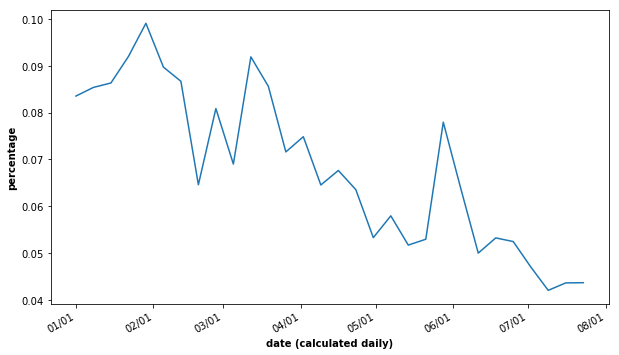

In [23]:
splitted_df = draw_graph(df, splitted=False)

/homes/jhpark/anaconda2/envs/tf/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


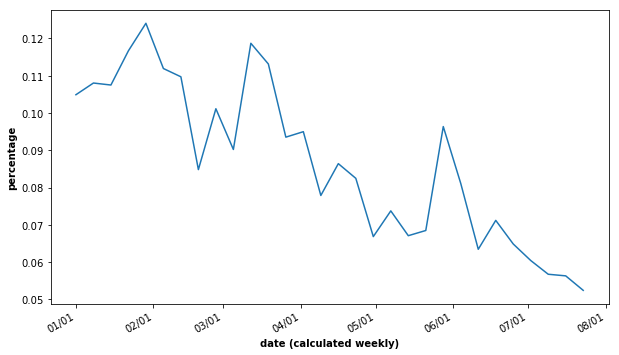

In [28]:
splitted_df = draw_graph(splitted_df, splitted=True)

In [90]:
total_count = 0
total_abusive = 0

for timeframe in splitted_df:
    total_abusive += timeframe["agree_count"]
    total_count += len(timeframe["df"])
total_abusive/total_count, total_abusive, total_count

(0.07319570204032355, 30314, 414150)

In [33]:
total_texts = []
total_gender = []
total_location = []

abusive_texts = []
abusive_gender = []
abusive_location = []

for timeframe in splitted_df:
    texts = timeframe["df"].text.tolist()
    gender = timeframe["df"].user_gender.tolist()
    location = timeframe["df"].location.tolist()
    assert len(texts) == len(gender) and len(gender) == len(location)
    assert len(timeframe["hybrid_preds"]) == len(texts)
    
    for i, pred in enumerate(timeframe["hybrid_preds"]):
        if timeframe["word_preds"][i] == pred and pred == 1:
            abusive_texts.append(texts[i])
            abusive_gender.append(gender[i])
            abusive_location.append(location[i])
            
    total_texts += texts
    total_gender += gender
    total_location +=  location

assert len(total_texts) == len(total_gender) and len(total_texts) == len(total_location)

In [34]:
random.sample(abusive_texts, 100)

['Did this bitch just refer to her email as a nothing Burger? #Hillary #Tucker',
 "All along they knew. And @HillaryClinton was attacked from all angles. She's bad ass",
 "@noelcourage @VABVOX @HillaryClinton @ChelseaClinton What kind of Woman LET'S MEN convince her to hate Women in power, & to demand silence?",
 '@sophievodka @VitalVoices If @HillaryClinton is a "queen" does that make her followers her little serfs? #LockHerUp #crookedclintons',
 '@tonyposnanski @HillaryClinton Lmao you are too... Amazingly stupid that is',
 "#President Trump gets full control her ass is going down! I can't wait! If they execute her publicly you will hear a deafening applause! @JebSanford @HillaryClinton Sorry can't do that she may decide to come and live in the UK.",
 "@bocavista2016 @HillaryClinton @billclinton & @ChelseaClinton don't view #rape as a crime. I'll bet #slickwilly was in #Sweden #Sexual 👇\U0001f3fd",
 '@ljkoolone @lely_01 @MissMandyHale @M2theM77 @HillaryClinton Zip it, bozo.',
 "@Patr

#### total gender

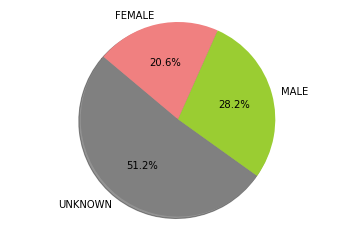

In [35]:
plt.pie([total_gender.count("UNKNOWN"), total_gender.count("MALE"), total_gender.count("FEMALE")] , 
        labels=["UNKNOWN", "MALE", "FEMALE"], colors=['grey', 'yellowgreen', 'lightcoral'],
        shadow=True, startangle=140, autopct='%1.1f%%')
 
plt.axis('equal')
plt.show()

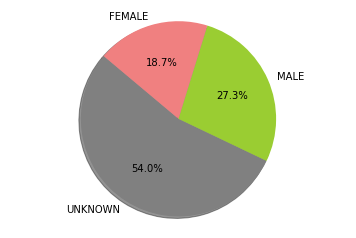

In [36]:
plt.pie([abusive_gender.count("UNKNOWN"), abusive_gender.count("MALE"), abusive_gender.count("FEMALE")] , 
        labels=["UNKNOWN", "MALE", "FEMALE"], colors=['grey', 'yellowgreen', 'lightcoral'],
        shadow=True, startangle=140, autopct='%1.1f%%')
 
plt.axis('equal')
plt.show()

In [37]:
from collections import Counter
total_location_counter= Counter(total_location)
abusive_location_counter= Counter(abusive_location)


In [38]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    "Unknown": "UNKNOWN"
}

codes_key = {}
for key in us_state_abbrev:
    codes_key[us_state_abbrev[key]] = key

In [43]:
for i, (state, count) in enumerate(total_location_counter.most_common(26)):
    if state != "None":
        print("%s: %s" % (i, codes_key[state]))

1: Unknown
2: California
3: New York
4: Florida
5: Texas
6: Washington
7: Pennsylvania
8: Illinois
9: Massachusetts
10: North Carolina
11: Virginia
12: Ohio
13: Georgia
14: Arizona
15: New Jersey
16: Michigan
17: Colorado
18: Tennessee
19: Nevada
20: Missouri
21: Oregon
22: Maryland
23: Indiana
24: South Carolina
25: Minnesota


In [44]:
for i, (state, count) in enumerate(abusive_location_counter.most_common(26)):
    if state != "None":
        print("%s: %s" % (i, codes_key[state]))
    

1: Unknown
2: California
3: New York
4: Florida
5: Texas
6: Pennsylvania
7: Washington
8: Illinois
9: North Carolina
10: Arizona
11: Virginia
12: Ohio
13: Georgia
14: Massachusetts
15: New Jersey
16: Colorado
17: Michigan
18: Nevada
19: Tennessee
20: Missouri
21: Indiana
22: Oregon
23: Maryland
24: South Carolina
25: Alabama


## co-occuring words

In [55]:
from collections import Counter
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk import pos_tag
import string

In [46]:
stopWords = set(stopwords.words('english'))
translator = str.maketrans('', '', string.punctuation)
tknzr = TweetTokenizer(reduce_len=True, preserve_case=False, strip_handles=False)

In [47]:
total_words = Counter()
true_words = Counter()

In [48]:
tknzr.tokenize("#hello world")

['#hello', 'world']

In [50]:
for tokens in [tknzr.tokenize(t.translate(translator)) for t in abusive_texts]:
    words = list(filter(lambda x: x not in stopWords, tokens))
    true_words.update(words)
for tokens in [tknzr.tokenize(t.translate(translator)) for t in total_texts]:
    total_words.update(list(filter(lambda x: x not in stopWords, tokens)))

In [51]:
len(total_words), len(true_words)

(188005, 40111)

In [81]:
remove = ["MD", "DT", "RP", "IN", "RB", "VB", "CD"]
blacklist = ["dont", "u", "didnt", "im", "right", "🇺", "🇸"]
_total_words = list(filter(lambda word: pos_tag([word[0]])[0][1] not in remove and word[0] not in blacklist, total_words.most_common(1000)))


In [82]:
for word, count in _total_words:
    print("%s %s" % (word, count))

hillaryclinton 383388
hillary 52298
realdonaldtrump 36938
trump 36729
potus 30937
president 19216
election 17360
us 15998
foxnews 15477
lost 15382
barackobama 15025
people 14982
clinton 14485
russia 12694
obama 11288
cnn 11200
dnc 10794
😂 10679
think 10382
emails 10358
need 10215
comey 10201
time 10098
thank 10046
vote 9669
love 9484
please 8784
billclinton 8690
youre 8369
said 8363
cant 8260
voted 8166
want 8083
good 8040
news 7938
going 7874
thats 7634
maga 7611
america 7550
fbi 7471
much 7432
women 7388
sensanders 7341
got 7122
media 7094
campaign 7091
shes 6937
day 6673
fake 6512
gop 6408
stop 6323
win 6151
today 6054
woman 6037
country 5987
many 5948
yes 5917
new 5775
way 5632
w 5532
️ 5499
dems 5422
nothing 5380
womensmarch 5221
democrats 5213
real 5198
thedemocrats 5145
oh 5137
great 5081
investigation 5033
better 4999
help 4927
look 4921
berniesanders 4916
russian 4837
says 4830
lol 4756
bernie 4693
hope 4660
votes 4640
doesnt 4598
made 4507
hrc 4431
party 4379
debate 4373
god 

In [83]:
remove = ["MD", "DT", "RP", "IN", "RB", "VB", "CD"]
_true_words = list(filter(lambda word: pos_tag([word[0]])[0][1] not in remove and word[0] not in blacklist, true_words.most_common(1000)))


In [84]:
for word, count in _true_words:
    print("%s %s" % (word, count))

hillaryclinton 28098
hillary 4374
realdonaldtrump 2286
potus 2016
trump 1935
ass 1792
foxnews 1727
women 1675
bitch 1161
clinton 1087
woman 1049
people 969
lost 956
😂 927
shes 889
obama 879
barackobama 841
billclinton 813
us 787
youre 782
white 759
president 694
think 678
america 673
cant 659
said 658
womensmarch 655
cnn 646
loser 637
time 608
want 606
thats 594
shit 586
got 574
lying 568
sensanders 554
fuck 548
fucking 538
men 531
hate 526
vote 518
need 517
rights 502
bill 487
dnc 473
real 460
child 459
lol 452
corrupt 451
stop 451
man 449
prison 441
rapist 439
good 437
jail 430
lockherup 423
much 419
doesnt 419
many 416
going 415
evil 410
voted 408
nothing 407
comey 405
chelseaclinton 403
maga 402
stupid 402
country 399
look 396
needs 396
husband 395
god 390
criminal 389
muslim 386
racist 382
election 382
americans 376
old 370
shut 368
liberals 368
better 367
house 365
hell 360
r 358
dumb 357
democrats 352
liar 351
w 343
ur 343
face 339
please 338
isnt 337
yes 336
thank 332
bad 330
l

In [87]:
s = ""
for word, count in _total_words[:300]:
    for _ in range(int(count/100)):
        s += ("%s " % word)
s

'hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillarycl

In [89]:
s = ""
for word, count in _true_words[:300]:
    for _ in range(int(count/100)):
        s += ("%s " % word)
s

'hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillaryclinton hillarycl

In [91]:
with open("hillary_stats.txt", "w") as f:
    for timeframe in splitted_df:
        s = "%s\t%s\t%s\n" % (timeframe["date"], timeframe["agree_count"], len(timeframe["df"]))
        f.write(s)
        print(s)

2017-01-01 00:00:00	883	10570

2017-01-08 00:00:00	1341	15705

2017-01-15 00:00:00	1426	16518

2017-01-22 00:00:00	2876	31268

2017-01-29 00:00:00	2175	21954

2017-02-05 00:00:00	1276	14221

2017-02-12 00:00:00	2062	23786

2017-02-19 00:00:00	1371	21218

2017-02-26 00:00:00	1590	19662

2017-03-05 00:00:00	1253	18153

2017-03-12 00:00:00	1210	13166

2017-03-19 00:00:00	1330	15535

2017-03-26 00:00:00	1483	20708

2017-04-02 00:00:00	1182	15789

2017-04-09 00:00:00	644	9975

2017-04-16 00:00:00	346	5114

2017-04-23 00:00:00	383	6025

2017-04-30 00:00:00	256	4801

2017-05-07 00:00:00	962	16594

2017-05-14 00:00:00	666	12875

2017-05-21 00:00:00	686	12949

2017-05-28 00:00:00	1101	14122

2017-06-04 00:00:00	1214	19024

2017-06-11 00:00:00	547	10936

2017-06-18 00:00:00	457	8580

2017-06-25 00:00:00	347	6612

2017-07-02 00:00:00	271	5757

2017-07-09 00:00:00	209	4968

2017-07-16 00:00:00	582	13332

2017-07-23 00:00:00	185	4233

